# 聚类算法实践  

- Kmeans与DBSCAN算法
- 半监督问题解决方案
- 聚类评估方法

In [4]:
import numpy as np
import os
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['axes.labelsize']=14
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12

import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

## Kmeans算法

In [104]:
from sklearn.datasets import make_blobs

blob_center = np.array( 
    [[0.2,2.3],
     [-1.5,2.3],
     [-2.8,1.8],
     [-2.8,2.8],
     [-2.8,1.3]])

blob_std = np.array([0.4,0.3,0.1,0.1,0.1])

X,y = make_blobs(n_samples=2000,
    centers=blob_center,
    cluster_std=blob_std,
    random_state=88)

In [105]:
X

array([[-2.85625505,  2.58626234],
       [-3.01271062,  1.23515058],
       [ 0.17544494,  2.48558471],
       ...,
       [-1.37031478,  2.49128355],
       [-1.41800841,  2.22059511],
       [-0.22390379,  2.26482003]])

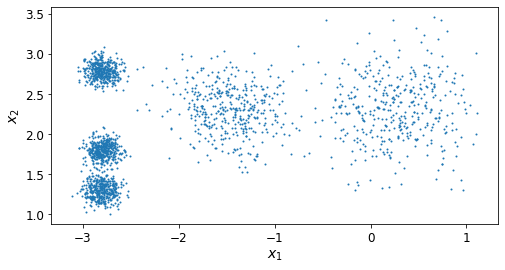

In [106]:
def plot_clusters(X,y=None):
    plt.scatter(X[:,0],X[:,1],c=y,s=1)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    
plt.figure(figsize=(8,4))
plot_clusters(X)
plt.show()

## 0.熟悉KMeans算法的属性和方法

In [107]:
from sklearn.cluster import KMeans
k = 5
kmeans = KMeans(n_clusters=k,random_state=8)
kmeans.fit(X)

KMeans(n_clusters=5, random_state=8)

#### 每个样本所属最近的聚类

In [108]:
kmeans.fit_predict(X)

array([3, 4, 2, ..., 0, 0, 2])

In [109]:
kmeans.predict(X)

array([3, 4, 2, ..., 0, 0, 2])

In [110]:
kmeans.labels_

array([3, 4, 2, ..., 0, 0, 2])

#### 获取聚类中心的坐标

In [111]:
kmeans.cluster_centers_

array([[-1.45083952,  2.30833663],
       [-2.78950859,  1.80381718],
       [ 0.26366168,  2.31500797],
       [-2.78851458,  2.78757952],
       [-2.80584409,  1.30156677]])

#### 每个样本到中心点的距离

In [112]:
kmeans.fit_transform(X)

array([[1.43263237, 0.7852869 , 3.13168635, 0.21240852, 1.28568424],
       [1.89503816, 0.61090166, 3.4497402 , 1.56853418, 0.21726682],
       [1.63591504, 3.04232747, 0.19203807, 2.97930477, 3.2078003 ],
       ...,
       [0.19988449, 1.57693408, 1.64345738, 1.4488209 , 1.86444909],
       [0.09368275, 1.43342826, 1.68431829, 1.48315828, 1.66454227],
       [1.2277072 , 2.60669362, 0.49014173, 2.61734713, 2.75577077]])

In [113]:
kmeans.transform(X)

array([[1.43263237, 0.7852869 , 3.13168635, 0.21240852, 1.28568424],
       [1.89503816, 0.61090166, 3.4497402 , 1.56853418, 0.21726682],
       [1.63591504, 3.04232747, 0.19203807, 2.97930477, 3.2078003 ],
       ...,
       [0.19988449, 1.57693408, 1.64345738, 1.4488209 , 1.86444909],
       [0.09368275, 1.43342826, 1.68431829, 1.48315828, 1.66454227],
       [1.2277072 , 2.60669362, 0.49014173, 2.61734713, 2.75577077]])

#### 样本到其最近聚类中心的平方距离之和（评估聚类效果）

In [114]:
kmeans.inertia_

217.33040713236184

In [115]:
X_dist = kmeans.transform(X)
X_label = kmeans.labels_
np.sum(X_dist[np.arange(len(X_dist)),X_label]**2)

217.33040713236164

In [116]:
kmeans.score(X)

-217.33040713236184

#### 测试实例

In [117]:
X_new = np.array([[0,2],[3,2],[-3,3],[-3,2.5]])
kmeans.predict(X_new)

array([2, 2, 3, 3])

In [118]:
kmeans.transform(X_new)

array([[1.48324199, 2.79639873, 0.41078888, 2.89760161, 2.89146503],
       [4.46150691, 5.79283155, 2.75441054, 5.84184753, 5.84770336],
       [1.69655428, 1.21456164, 3.33477161, 0.29974746, 1.70949465],
       [1.56097183, 0.72730816, 3.26890037, 0.35697067, 1.21405878]])

## **2.可视化展示（聚类中心点和决策边界）

In [119]:
# 数据点
def plot_data(X):
    plt.plot(X[:,0],X[:,1],'k.',markersize=2)
 
    
# 中心点    
def plot_centroids(centroids,weights=None,circle_color='w',cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max()/10]
    plt.scatter(centroids[:,0],centroids[:,1],
                marker='o',s=20,linewidths=8,
                color=circle_color,zorder=10,alpha=0.9)
    plt.scatter(centroids[:,0],centroids[:,1],
                marker='x',s=30,linewidths=30,
                color=cross_color,zorder=11,alpha=1)        

# 决策边界
def plot_decision_boundaries(clusterer,X,resolution=1000,
                            show_centroids=True,show_xlabels=True,show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    
    xx,yy = np.meshgrid(np.linspace(mins[0],maxs[0],resolution),
                        np.linspace(mins[1],maxs[1],resolution))
    Z = clusterer.predict(np.c_[xx.ravel(),yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # plt.contourf 绘制区域颜色
    plt.contourf(Z,extent=(mins[0],maxs[0],mins[1],maxs[1]),cmap='Pastel2')
    
    # plt.contour 绘制等高线
    plt.contour(Z,extent=(mins[0],maxs[0],mins[1],maxs[1]),linewidths=1,colors='k')
    
    # 绘制数据点
    plot_data(X)
    
    # 绘制中心点
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)    
    
    # 绘制x、y轴
    if show_xlabels:
        plt.xlabel('$x_1$',fontsize=14)
    else:
        plt.tick_params(labelbottom='off')
    if show_ylabels:
        plt.xlabel('$x_2$',fontsize=14,rotation=0)
    else:
        plt.tick_params(labelleft='off')
    

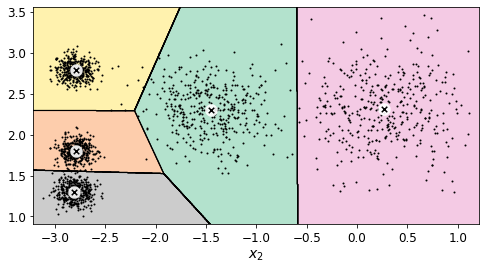

In [120]:
blob_center = np.array( 
    [[0.2,2.3],
     [-1.5,2.3],
     [-2.8,1.8],
     [-2.8,2.8],
     [-2.8,1.3]])

blob_std = np.array([0.4,0.3,0.1,0.1,0.1])

X,y = make_blobs(n_samples=2000,
    centers=blob_center,
    cluster_std=blob_std,
    random_state=88)

k = 5
kmeans = KMeans(n_clusters=k,random_state=8)
kmeans.fit(X)


plt.figure(figsize=(8,4))
plot_decision_boundaries(kmeans,X)

plt.show()

## 3.Kmeans算法流程

In [121]:
kmeans_iter1 = KMeans(n_clusters=5,init='random',max_iter=1,random_state=8)
kmeans_iter2 = KMeans(n_clusters=5,init='random',max_iter=2,random_state=8)
kmeans_iter3 = KMeans(n_clusters=5,init='random',max_iter=3,random_state=8)

kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

KMeans(init='random', max_iter=3, n_clusters=5, random_state=8)

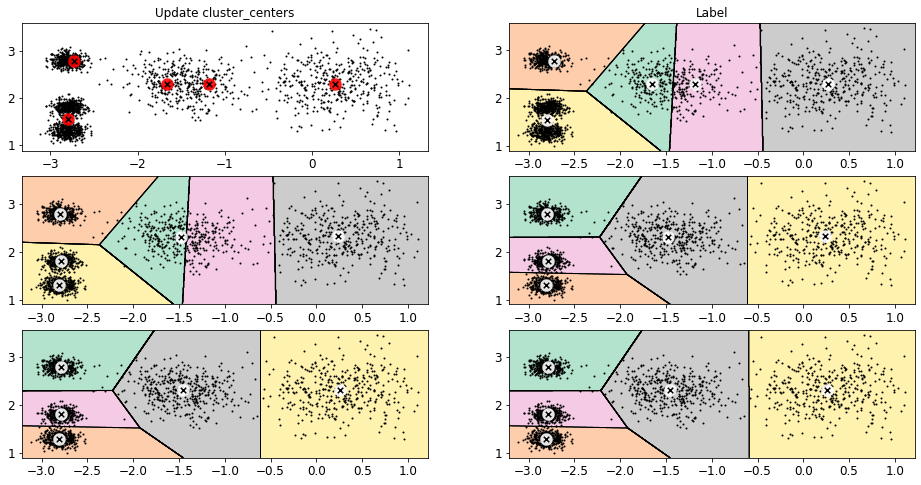

In [122]:
plt.figure(figsize=(16,8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_,
               weights=None,circle_color='r',cross_color='k')
plt.title('Update cluster_centers')

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1,X,show_xlabels=False,show_ylabels=False)
plt.title('Label')

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1,X,show_centroids=False,show_xlabels=False,show_ylabels=False)
plot_centroids(kmeans_iter2.cluster_centers_,
               weights=None,circle_color='w',cross_color='k')

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2,X,show_xlabels=False,show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2,X,show_centroids=False,show_xlabels=False,show_ylabels=False)
plot_centroids(kmeans_iter3.cluster_centers_,
               weights=None,circle_color='w',cross_color='k')

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3,X,show_xlabels=False,show_ylabels=False)

plt.show()

## 4.聚类效果评估，找到最佳簇数 

### inertia_ 属性（仅供参考）:不能直接作为实际聚类效果的评估指标
- 样本到其最近聚类中心的平方距离之和，如果k值越大，得到的结果肯定会越来越小，关键是找到拐点

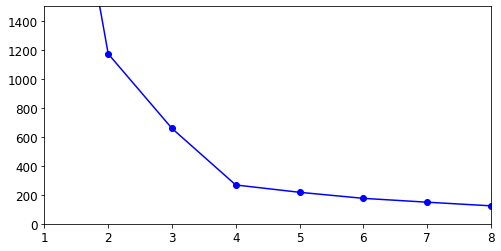

In [123]:
kmeans_per_k = [KMeans(n_clusters=k).fit(X) for k in range(1,10)] 
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8,4))
plt.plot(range(1,10),inertias,'bo-')
plt.axis([1,8,0,1500])
plt.show()

### 轮廓系数（仅供参考）
  - 样本的簇内相似度 ai：计算样本到同簇其他样本的平均距离，ai越小，说明样本越应该被聚类到该簇
  - 样本的簇间相似度 bi：计算样本i到其他簇Cj的所有样本的平均距离，bi越大，说明样本越不应该被聚类到该簇

![轮廓系数](轮廓系数.png)

结论：
   - si接近1，则说明样本i聚合合理
   - si接近-1，则说明样本i更应该被分类到另外的簇
   - si近似为0:，则说明样本i在两个簇的边界上

In [124]:
from sklearn.metrics import silhouette_score
silhouette_score(X,kmeans.labels_)

0.6565522101698973

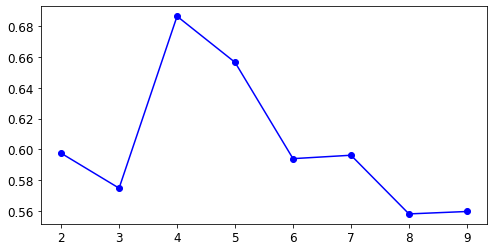

In [125]:
kmeans_per_k = [KMeans(n_clusters=k).fit(X) for k in range(2,10)] 
silhouette_scores = [silhouette_score(X,model.labels_) for model in kmeans_per_k]

plt.figure(figsize=(8,4))
plt.plot(range(2,10),silhouette_scores,'bo-')
plt.show()

## 5.Kmeans存在的问题

### 不稳定的结果：初始质心对结果影响很大

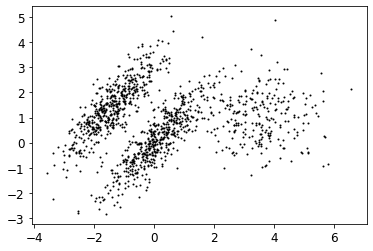

In [126]:
X1,y1 = make_blobs(n_samples=1000,centers=((4,-4),(0,0)),random_state=42)
X1 = X1.dot(np.array([[0.375,0.95],[0.732,0.588]]))
X2,y2 = make_blobs(n_samples=250,centers=1,random_state=42)
X2 = X2 + [6,-8]
X = np.r_[X1,X2]
y = np.r_[y1,y2]

plot_data(X)

In [127]:
kmeans_good = KMeans(n_clusters=3,init=np.array([[-1.5,2.5],[0.5,0],[4,0]]),n_init=1,random_state=11)
kmeans_bad = KMeans(n_clusters=3,random_state=11)
kmeans_good.fit(X)
kmeans_bad.fit(X)

KMeans(n_clusters=3, random_state=11)

Text(0.5, 1.0, 'bad-inertia=2195.155689033184')

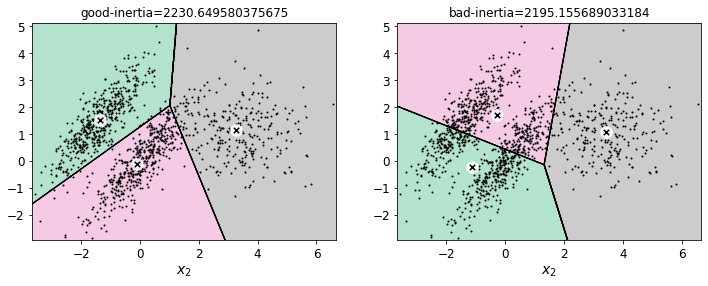

In [128]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plot_decision_boundaries(kmeans_good,X)
plt.title('good-inertia={}'.format(kmeans_good.inertia_))

plt.subplot(122)
plot_decision_boundaries(kmeans_bad,X)
plt.title('bad-inertia={}'.format(kmeans_bad.inertia_))

再次验证‘inertia_’不能直接作为实际聚类效果的评估指标

### 不稳定的结果：随机种子、运行次数对的结果影响

Text(0.5, 1.0, 'init=k-means++,random_state=11,inertia=2230.65')

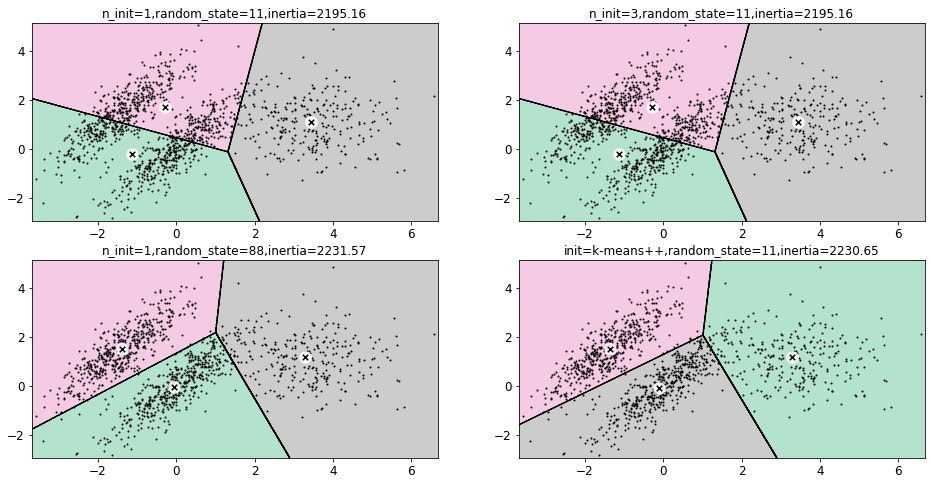

In [129]:
cl1 = KMeans(n_clusters=3,init='random',n_init=1,random_state=11)
cl2 = KMeans(n_clusters=3,init='random',n_init=10,random_state=11)
cl3 = KMeans(n_clusters=3,init='random',n_init=1,random_state=88)
cl4 = KMeans(n_clusters=3,init='k-means++',n_init=1,random_state=11)

cl1.fit(X)
cl2.fit(X)
cl3.fit(X)
cl4.fit(X)

plt.figure(figsize=(16,8))
plt.subplot(221)
plot_decision_boundaries(cl1,X,show_xlabels=False,show_ylabels=False)
plt.title('n_init=1,random_state=11,inertia={:.2f}'.format(cl1.inertia_))

plt.subplot(222)
plot_decision_boundaries(cl2,X,show_xlabels=False,show_ylabels=False)   
plt.title('n_init=3,random_state=11,inertia={:.2f}'.format(cl2.inertia_))


plt.subplot(223)
plot_decision_boundaries(cl3,X,show_xlabels=False,show_ylabels=False)    
plt.title('n_init=1,random_state=88,inertia={:.2f}'.format(cl3.inertia_))

plt.subplot(224)
plot_decision_boundaries(cl4,X,show_xlabels=False,show_ylabels=False)    
plt.title('init=k-means++,random_state=11,inertia={:.2f}'.format(cl4.inertia_))

## 应用实例：图形分割

In [178]:
from matplotlib.image import imread
image = imread('ladybug.jpg')
image.shape

(1001, 1001, 3)

In [179]:
X = image.reshape(-1,3)
X.shape

(1002001, 3)

In [166]:
kms = KMeans(n_clusters=8,random_state=42).fit(X)

In [167]:
kms.cluster_centers_

array([[0.69796675, 0.37493545, 0.1854667 ],
       [0.99900925, 0.99813485, 0.9982556 ],
       [0.19347578, 0.1525532 , 0.10890937],
       [0.7789405 , 0.6701455 , 0.7625207 ],
       [0.9001118 , 0.5446499 , 0.09194446],
       [0.6237629 , 0.47128052, 0.53617   ],
       [0.9225951 , 0.7158546 , 0.36341438],
       [0.42828462, 0.28825974, 0.19701707]], dtype=float32)

In [168]:
kms.labels_.shape

(1001472,)

In [169]:
kms.cluster_centers_[kms.labels_].shape

(1001472, 3)

In [171]:
kms.cluster_centers_[kms.labels_].reshape(image.shape).shape

(978, 1024, 3)

In [ ]:
segmented_imgs = []
n_colors = (10,8,6,4,2)
for n_clusters in n_colors:
    kms = KMeans(n_clusters=n_clusters,random_state=42).fit(X)
    segmented_img = kms.cluster_centers_[kms.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))
    
plt.figure(figsize=(14,6))
plt.subplot(231)
plt.imshow(image)
plt.title('Original image')

for idx,n_clusters in enumerate(n_colors):
    plt.subplot(232+idx)
    plt.imshow(segmented_imgs[idx]/255)
    plt.title('{}colors'.format(n_clusters))


## 5.半监督学习

In [1]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans

In [2]:
X_digits,y_digits = load_digits(return_X_y=True)
X_train,X_test,y_train,y_test = train_test_split(X_digits,y_digits,random_state=42)

In [5]:
#逻辑回归直接预测的评分
n_labeled = 50

log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train[:n_labeled],y_train[:n_labeled])
log_reg.score(X_test,y_test)

0.8266666666666667

### 第一步：kmeans聚类，找到每个聚类最靠近质心的代表图像，并手动标记它们

In [6]:
k = 50
kmeans = KMeans(n_clusters=k,random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)
X_representative_digits = X_train[np.argmin(X_digits_dist,axis=0)]

In [7]:
X_digits_dist.shape

(1347, 50)

In [8]:
X_representative_digits.shape

(50, 64)

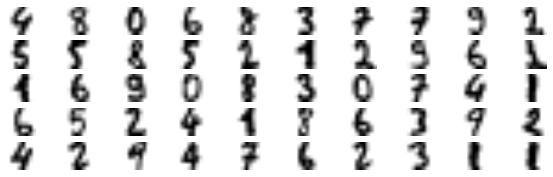

In [9]:
from matplotlib.image import imread

plt.figure(figsize=(10,3))
for idx,X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k//10,10,idx+1)
    plt.imshow(X_representative_digit.reshape(8,8),cmap='binary',interpolation='bilinear')
    plt.axis('off')
    
plt.show()

In [10]:
y_representative_digits = np.array([
    4,8,0,6,8,3,7,7,9,2,
    5,5,8,5,2,1,2,9,6,1,
    1,6,9,0,8,3,0,7,4,1,
    6,5,2,4,1,8,6,3,9,2,
    4,2,9,4,7,6,2,3,1,1])

In [11]:
# kmeans聚类后的预测评分
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_representative_digits,y_representative_digits)
log_reg.score(X_test,y_test)

0.92

### 第二步：标签传播

In [12]:
y_representative_digits[1]

8

In [13]:
y_train[kmeans.labels_== 1]

array([8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8,
       8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])

In [14]:
y_train_propagated = np.empty(len(X_train))
for i in range(k):
    y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]

log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train,y_train_propagated)
log_reg.score(X_test,y_test)

0.9288888888888889

### 第三步：选择簇内前20%样本进行标签传播

In [16]:
percentile_closest = 20
X_cluster_dist = X_digits_dist[np.arange(len(X_train)),kmeans.labels_]

for i in range(k):
    in_cluster = (kmeans.labels_==i)
    cluster_dist = X_cluster_dist[in_cluster]  #选择属于当前簇的所有样本
    cutoff_distance = np.percentile(cluster_dist,percentile_closest)  #排序找到前20个
    above_cutoff = (X_cluster_dist > cutoff_distance) #判断样本到簇中心的距离是否大于前20距离，返回false true结果
    X_cluster_dist[in_cluster & above_cutoff] = -1  #标记为-1
    
partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_partially_propagated,y_train_partially_propagated)
log_reg.score(X_test,y_test)

0.9444444444444444